## Introduction to Estimation

Estimation is a branch of the Analysis Phase to use when you are testing for a continuous variable.  

In [1]:
# Import libraries:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Workshop Functions
import sys
sys.path.append('..')
from Wksp722_functions import * 

In [2]:
# Read in data
housing = pd.read_csv("housing.csv")
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:
housing.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

### Next Steps
Let's try to replace the missing 'total_bedrooms' column with the median value for that variable.  

In [5]:
median = housing.loc[:,"total_bedrooms"].median()
housing.loc[:,"total_bedrooms"].fillna(median, inplace=True)

housing.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

Next, let's look at the variables and see how they're correlated

In [6]:
corr_matrix=housing.corr()
corr_matrix.median_house_value.sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049457
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

It looks like 'median_income' has a high correlation to the median_house_value.  

Another Kaggle user created a new variable by dividing the total_rooms and total_bedrooms by households.  On their own, total_rooms, total_bedrooms and households are good indicators of housing density in an area.  The new normalized values give the number of rooms and bedrooms per household, which can be a better indicator of house side.  

In [7]:
housing.loc[:,'rooms_per_household'] = housing.loc[:,'total_rooms']/housing.loc[:,'households']
housing.loc[:,'bedrooms_per_household'] = housing.loc[:,'total_bedrooms']/housing.loc[:,'households']

In [8]:
# re-run correlation
corr_matrix=housing.corr()
corr_matrix.median_house_value.sort_values(ascending=False)

median_house_value        1.000000
median_income             0.688075
rooms_per_household       0.151948
total_rooms               0.134153
housing_median_age        0.105623
households                0.065843
total_bedrooms            0.049457
population               -0.024650
bedrooms_per_household   -0.045637
longitude                -0.045967
latitude                 -0.144160
Name: median_house_value, dtype: float64

The 'rooms_per_household' had a high correlation to the median_house_value.  This *may* be useful to analyses models.  

Lattitude also has a high correlation value.  I'm using code from a Kaggle notebook found here: https://www.kaggle.com/code/mostafaashraf1/california-housing-prices

The map shows clustering of high value homes around the coast between San Fransciso and San Diego.  These are also highly populated areas. 

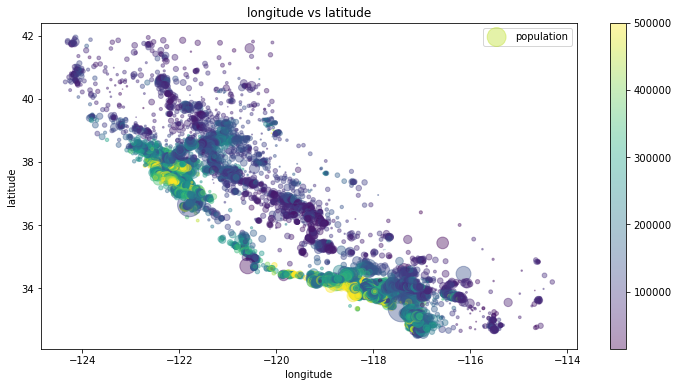

In [9]:
M3L4_CA_plot(housing)

In [10]:
#### Convert ocean_proximity to numerical columns using One-Hot encoding
dfTemp = pd.get_dummies(housing.loc[:,'ocean_proximity'],dtype=int)

housing = pd.concat([housing,dfTemp], axis=1)
housing.drop('ocean_proximity', axis=1,inplace=True)
housing.head(2)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_household,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,6.984127,1.02381,0,0,0,1,0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,6.238137,0.97188,0,0,0,1,0


### Normalizing variables
Some estimation algorithms require normally distributed variables.  We can use the RobustScaler function in Scikit-learn to normalize the variables.  But first, let's take a look at the distributions:

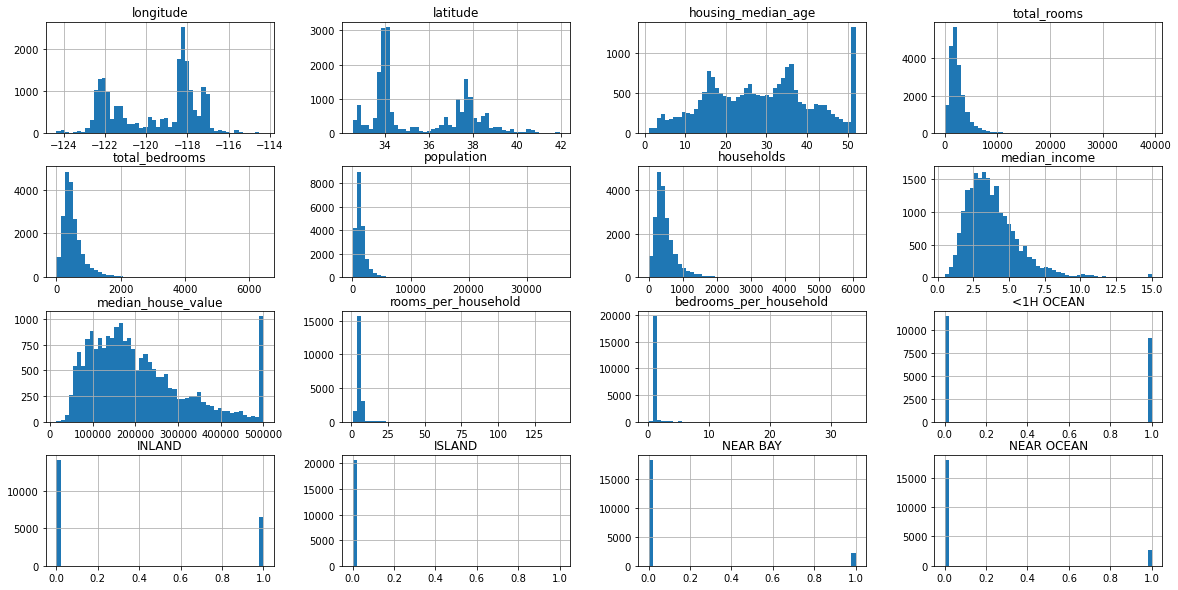

In [21]:
housing.hist(bins=50,figsize=(20,10))
plt.show()

We see that the distributions that seem to follow a Gaussian distribution (total_rooms, total_bedrooms, population, households, median_income, median_house_value), but have a longer right side tail.  RobustScaler will remove the median and scale the variance.   

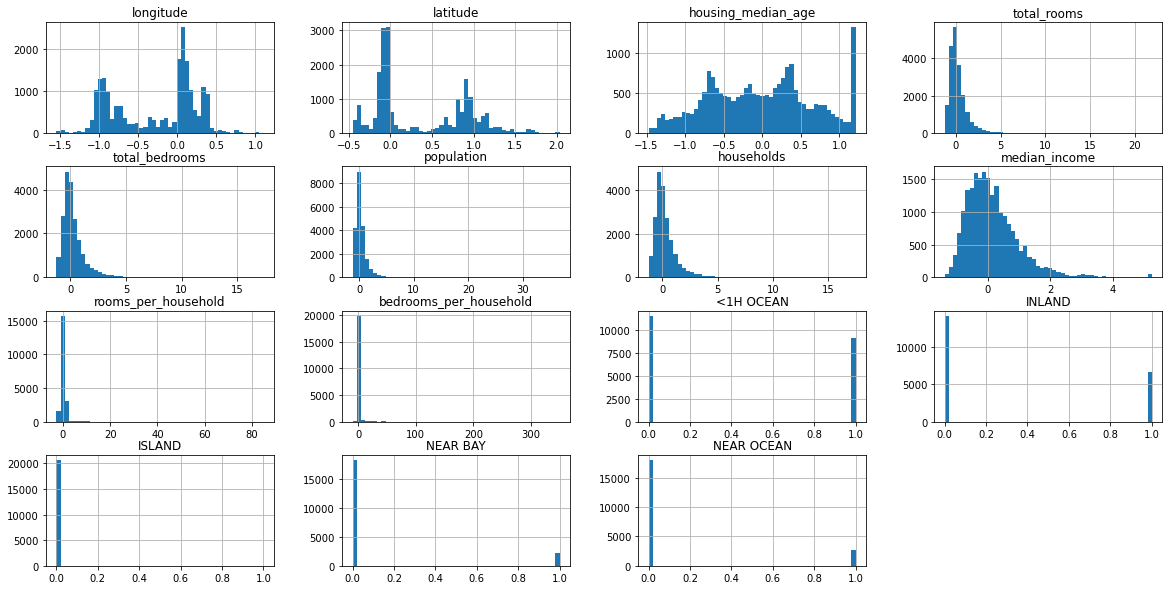

In [12]:
x = housing.drop(columns="median_house_value")
y = housing.loc[:,'median_house_value']

from sklearn.preprocessing import RobustScaler
ro_scaler = RobustScaler()
housingScaled = ro_scaler.fit_transform(x) #<-- only scale the input variables, not the target

housingScaled = pd.DataFrame(housingScaled, columns=x.columns)
housingScaled.hist(bins=50,figsize=(20,10));

While the distribution shapes for each variable have remained the same, the ranges have been adjusted to account for the longer tails and each variable has been normalized.  

We are now ready to work on the estimation algorithms:
* Linear Regression
* Decision Tree
* Random Forest (Regression)

In [13]:
# First let's define training and test sets
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3, random_state=1)

#### Linear Regression

In [14]:
# Linear Regression
from sklearn.linear_model import LinearRegression
LR = LinearRegression().fit(x_train,y_train)
y_pred_LR = LR.predict(x_test)

from sklearn.metrics import mean_squared_error, r2_score
rmse_LR = np.sqrt(mean_squared_error(y_pred_LR, y_test))
R2_LR = r2_score(y_pred_LR, y_test)

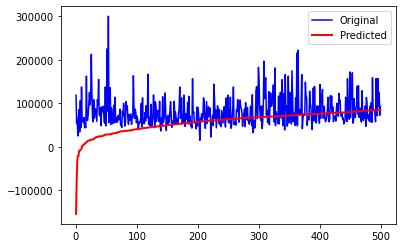

In [15]:
# Let's plot the actual vs predicted values
M3L4_Predicted_Plot(x_test, y_test, y_pred_LR, numPts = 500)

#### Decision Tree
First let's start with a small decision tree so we can take a look at it

In [16]:
# Decision Tree
from sklearn.tree import DecisionTreeRegressor
Tree = DecisionTreeRegressor(random_state=1, max_depth=3).fit(x_train, y_train)
y_pred_Tree = Tree.predict(x_test)

from sklearn.metrics import mean_squared_error, r2_score
print('RMSE = ',np.sqrt(mean_squared_error(y_pred_Tree, y_test)))
print('R2 = ', r2_score(y_pred_Tree, y_test))

RMSE =  75681.44649857095
R2 =  0.23350042576813324


In [1]:
y_pred_Tree

NameError: name 'y_pred_Tree' is not defined

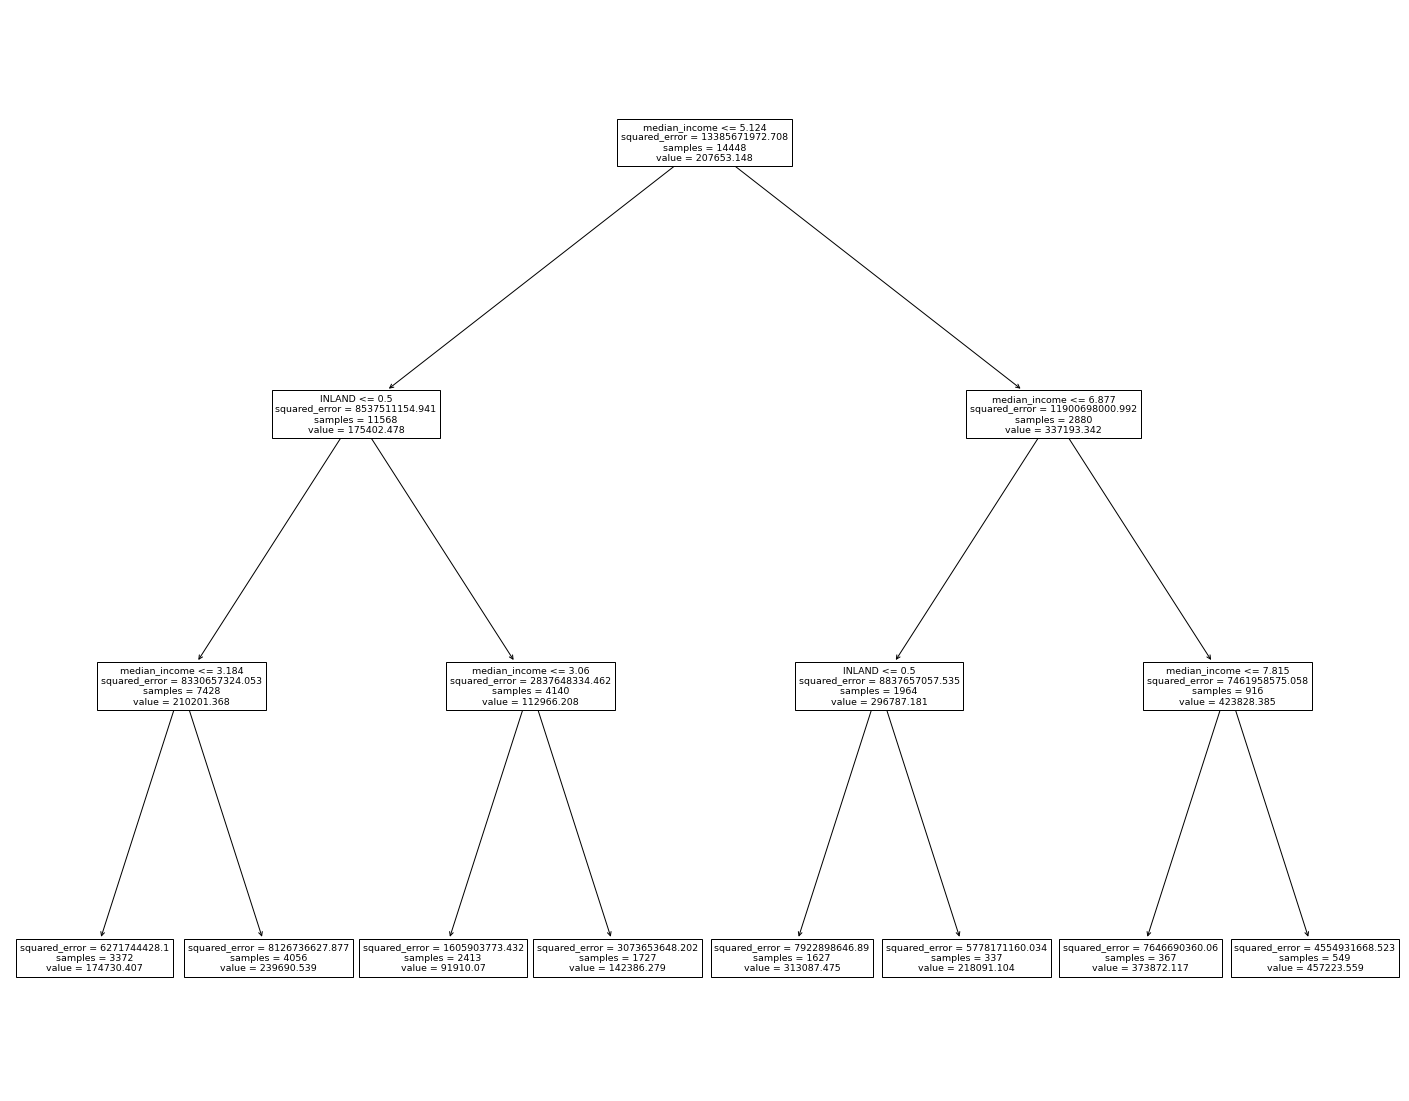

In [17]:
from sklearn import tree
fig = plt.figure(figsize=(25,20))
tree.plot_tree(Tree,feature_names=x_test.columns)

fig.savefig('treeRegression.pdf')

In [18]:
# Decision Tree - Full Length
from sklearn.tree import DecisionTreeRegressor
Tree = DecisionTreeRegressor(random_state=1, max_depth=None).fit(x_train, y_train)
y_pred_Tree = Tree.predict(x_test)

rmse_Tree = np.sqrt(mean_squared_error(y_pred_Tree, y_test))
R2_Tree = r2_score(y_pred_Tree, y_test)

print('mean house price = ', y_test.mean())
print(rmse_Tree, R2_Tree)
print('max tree depth = ', Tree.tree_.max_depth)

mean house price =  204995.37709948322
72059.36133172101 0.6096298861255868
max tree depth =  35


In [19]:
# Random Forest 
from sklearn.ensemble import RandomForestRegressor
RF = RandomForestRegressor(n_estimators = 100, max_depth=None, random_state=1)
RF.fit(x_train, y_train)
y_pred_RF = RF.predict(x_test)

from sklearn.metrics import mean_squared_error, r2_score
rmse_RF = np.sqrt(mean_squared_error(y_pred_RF, y_test))
R2_RF = r2_score(y_pred_RF, y_test)

#### Performance Summary

In [20]:
data = {'Estimator':['Linear Regression', 'Decision Tree','Random Forest'],
       'RMSE':[rmse_LR, rmse_Tree,rmse_RF],
       'R2 Score':[R2_LR, R2_Tree, R2_RF]}

EstimationMetrics = pd.DataFrame(data)
#print(EstimationMetrics)
display(EstimationMetrics) #<--- Nicer alternative to print for dataframes

,Estimator,RMSE,R2 Score
0,Linear Regression,68995.701305,0.467565
1,Decision Tree,72059.361332,0.609630
2,Random Forest,50254.799185,0.753088
